# Classification

Classification Problem - Amongst cases that made a bail plea, bail granted or not. 

### Data Pre-processing

So in the pre-processing part, I take all the cases data from cases_20xx tables. I filter out for only those cases whose disposition resulted in either 'bail granted' or 'bail rejected' i.e., the cases that made a bail plea.

I then split all the column that contains data into three other integer columns in hopes that these might act as useful features while training the model.

I drop all the columns like 'ddl_case_id','cino' since I was pretty sure these columns would not have any co-relation with the judgement results. I also drop gender related columns because I dont think those will have any co-relation either.

I lastly drop the disp_name column because it is what I am trying to classifying and if I dont drop it I will 100% accuray (lol).

I add a new column 'target_y' which is True if bail was granted and False if bail was rejected. (I also remove this column before training ofcourse xP).


In [2]:
paths = {
    "cases_2010" : "/home/ishwar/data/cases/cases/cases_2010.csv",
    "cases_2011" : "/home/ishwar/data/cases/cases/cases_2011.csv",
    "cases_2012" : "/home/ishwar/data/cases/cases/cases_2012.csv",
    "cases_2013" : "/home/ishwar/data/cases/cases/cases_2013.csv",
    "cases_2014" : "/home/ishwar/data/cases/cases/cases_2014.csv",
    "cases_2015" : "/home/ishwar/data/cases/cases/cases_2015.csv",
    "cases_2016" : "/home/ishwar/data/cases/cases/cases_2016.csv",
    "cases_2017" : "/home/ishwar/data/cases/cases/cases_2017.csv",
    "cases_2018" : "/home/ishwar/data/cases/cases/cases_2018.csv",
    "judges" : "/home/ishwar/data/judges_clean/judges_clean.csv",
    "judges_key" : "/home/ishwar/data/keys/keys/judge_case_merge_key.csv",
    "cases_state_key" : "/home/ishwar/data/keys/keys/cases_state_key.csv",
    "type_name_key" : "/home/ishwar/data/keys/keys/type_name_key.csv",
    "acts_sections" : "/home/ishwar/data/acts_sections/acts_sections.csv"
}

years = [2010, 2011, 2012, 2013 ,2014,2015 ,2016, 2017,2018]
cases = ["cases_2010","cases_2011","cases_2012", "cases_2013","cases_2014","cases_2015","cases_2016","cases_2017","cases_2018"]

import polars as pl
df = pl.read_csv(paths['cases_2010'],parse_dates=True)
list = [8,9]
df = df.filter(pl.col(['disp_name']).is_in(list))
for i in range(1,len(cases)):
    x = pl.read_csv(paths[cases[i]],parse_dates=True)
    x = x.filter(pl.col(['disp_name']).is_in(list))
    df = pl.concat([df,x])
df = df.drop_nulls()

def d(x):
    try:
        return x.day
    except:
        return 0

def m(x):
    try:
        return x.month
    except:
        return 0

def y(x):
    try:
        return x.year
    except:
        return 0

df = df.with_columns([
    (pl.col("date_next_list").apply(d)).alias("date_next_list_d"),
    (pl.col("date_next_list").apply(m)).alias("date_next_list_m"),
    (pl.col("date_next_list").apply(y)).alias("date_next_list_y"),

    (pl.col("date_last_list").apply(d)).alias("date_last_list_d"),
    (pl.col("date_last_list").apply(m)).alias("date_last_list_m"),
    (pl.col("date_last_list").apply(y)).alias("date_last_list_y"),

    (pl.col("date_first_list").apply(d)).alias("date_first_list_d"),
    (pl.col("date_first_list").apply(m)).alias("date_first_list_m"),
    (pl.col("date_first_list").apply(y)).alias("date_first_list_y"),

    (pl.col("date_of_decision").apply(d)).alias("date_of_decision_d"),
    (pl.col("date_of_decision").apply(m)).alias("date_of_decision_m"),
    (pl.col("date_of_decision").apply(y)).alias("date_of_decision_y"),

    (pl.col("date_of_filing").apply(d)).alias("date_of_filing_d"),
    (pl.col("date_of_filing").apply(m)).alias("date_of_filing_m"),
    (pl.col("date_of_filing").apply(y)).alias("date_of_filing_y"),
])

df = df.drop(["date_next_list","date_last_list","date_first_list","date_of_decision","date_of_filing"])

df = df.with_column(pl.col('disp_name').apply(lambda x : x == 8).alias("target_y"))

df =df.drop(['ddl_case_id','cino'])
df = df.drop(['female_defendant','female_petitioner','female_adv_def','female_adv_pet','judge_position'])
df =df.drop(['disp_name'])


# Training

Here I am using Naive Bayes Model to train the data. I am training on 80% of the data and then will test on the remaining 20%. Good thing about the train_test_split() function is that it well shuffles the data before spliting.

In [3]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df[['year','state_code','dist_code','court_no','type_name','purpose_name','date_next_list_d','date_next_list_m','date_next_list_y','date_last_list_d','date_last_list_m','date_last_list_y','date_first_list_d','date_first_list_m','date_first_list_y','date_of_decision_d','date_of_decision_m','date_of_decision_y','date_of_filing_d','date_of_filing_m','date_of_filing_y']], df['target_y'],test_size=0.2)

from sklearn.naive_bayes import GaussianNB
import numpy as np

clf = GaussianNB()

X_encoded = X_train
y_train = pl.DataFrame(y_train)

print(X_encoded,y_train)

clf.fit(X_encoded.to_numpy(), y_train.to_numpy().ravel())

shape: (91286, 21)
┌──────┬──────────┬───────────┬──────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ year ┆ state_co ┆ dist_code ┆ court_no ┆ ... ┆ date_of_de ┆ date_of_fi ┆ date_of_fi ┆ date_of_fi │
│ ---  ┆ de       ┆ ---       ┆ ---      ┆     ┆ cision_y   ┆ ling_d     ┆ ling_m     ┆ ling_y     │
│ i64  ┆ ---      ┆ i64       ┆ i64      ┆     ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│      ┆ i64      ┆           ┆          ┆     ┆ i64        ┆ i64        ┆ i64        ┆ i64        │
╞══════╪══════════╪═══════════╪══════════╪═════╪════════════╪════════════╪════════════╪════════════╡
│ 2018 ┆ 1        ┆ 30        ┆ 17       ┆ ... ┆ 2018       ┆ 3          ┆ 10         ┆ 2018       │
│ 2017 ┆ 1        ┆ 25        ┆ 1        ┆ ... ┆ 2017       ┆ 30         ┆ 5          ┆ 2017       │
│ 2018 ┆ 10       ┆ 7         ┆ 15       ┆ ... ┆ 2018       ┆ 9          ┆ 6          ┆ 2018       │
│ 2017 ┆ 1        ┆ 25        ┆ 24       ┆ ... ┆ 2017       ┆ 21        

GaussianNB()

# Testing

So I test the trained model on remaining 20% of the data. I get the predicted classes for test cases and compare them with actual y classes using various scores like precision_score, recall_score, f1_score , roc_auc_score, accuracy_score.

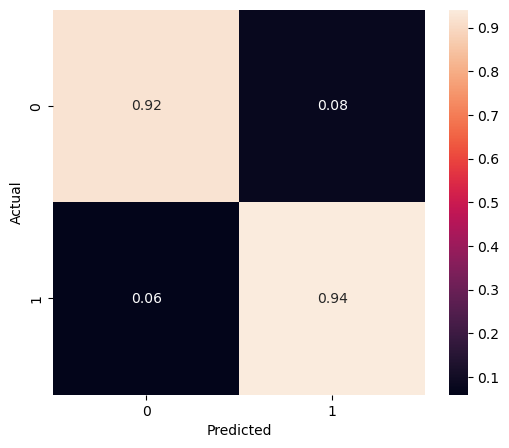

Confusion Matrix = 
 [[0.92307692 0.07692308]
 [0.05917368 0.94082632]]
precision_score =  0.9994847292486415
recall_score =  0.9408263150932581
f1_score =  0.9692688577463828
accuracy_score =  0.9407150994654281
roc_auc_score =  0.9319516190850907


/home/ishwar/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


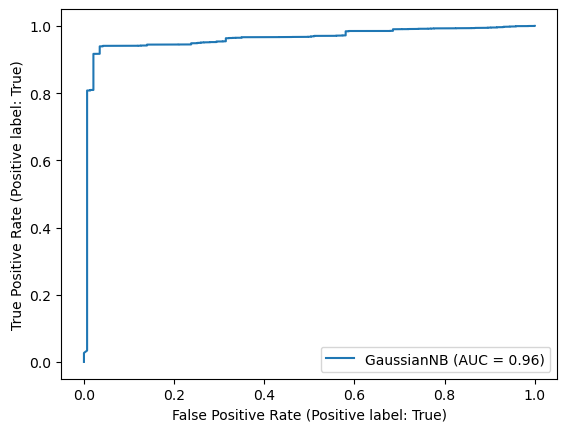

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = clf.predict(X_test.to_numpy())
x = confusion_matrix(y_test, y_train_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Normalise
x = x.astype('float') / x.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(x, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Confusion Matrix = \n",x)

from sklearn.metrics import precision_score, recall_score, f1_score , roc_auc_score, accuracy_score
a = precision_score(y_test, y_train_pred) 
b = recall_score(y_test, y_train_pred)
c = f1_score(y_test, y_train_pred)
d = accuracy_score(y_test, y_train_pred)
e = roc_auc_score(y_test, y_train_pred)
print("precision_score = ",a)
print("recall_score = ",b)
print("f1_score = ",c)
print("accuracy_score = ",d)
print("roc_auc_score = ",e)

from sklearn import metrics
metrics.plot_roc_curve(clf, X_test.to_numpy(), y_test.to_numpy().ravel()) 
plt.show()

### Analyzing Performance

The Model seems pretty good. It has Accuray around 0.94 and pretty good precision,recall and f1 scores

<img src="./assets/img18.png" alt="Drawing" style="width: 700px;"/>

Here precision is better than recall. That means the model is better at recognising True Positives over True Negatives

The confusion Matrix looks pretty neat - 

<img src="./assets/img15.png" alt="Drawing" style="width: 400px; height: 350px;"/>

And the roc curve looks like this - 

<img src="./assets/img16.png" alt="Drawing" style="width: 500px;"/>